# Using EcoFOCIpy to process raw field data

## CTD / Profile Data

Basic workflow for each instrument grouping is *(initial archive level)*:
- Parse data from raw files into pandas dataframe
- output initial files (pandas->csv) **ERDDAP NRT** when no meta data is added

Convert to xarray dataframe for all following work *(working or final data level):
- TODO: Add metadata from cruise yaml files and/or header info
- ingest metadata from cruiese / cast logs
- process data beyond simple file translate
- apply any calibrations or corrections
    + field corrections
    + offsets
    + instrument compensations
    + some QC were available... this would be old-school simple bounds mostly
- adjust time bounds and sample frequency (xarray dataframe)
- save as CF netcdf via xarray: so many of the steps above are optional
    + **ERDDAP NRT** if no corrections, offsets or time bounds are applied but some meta data is
    + **Working and awaiting QC** has no ERDDAP representation and is a holding spot
    + **ERDDAP Final** fully calibrated, qc'd and populated with meta information

Plot for preview and QC
- preview images (indiv and/or collectively)
- manual qc process
- automated qc process ML/AI

Further refinenments for ERDDAP hosting:


## Example below is for SBE 9/11+ V2 but the workflow is similar for any SBE instruments.

Future processing of this instrument can be a simplified (no markdown) process which can be archived so that the procedure can be traced or updated

We process each cast as an individual file so this example will not loop over all profiles.  See `example/all_casts.py` example for processing an entire cruise at once.

In [1]:
import yaml
import glob

import EcoFOCIpy.io.sbe_ctd_parser as sbe_ctd_parser #<- instrument specific
import EcoFOCIpy.io.ncCFsave as ncCFsave
import EcoFOCIpy.metaconfig.load_config as load_config

The sample_data_dir should be included in the github package but may not be included in the pip install of the package

## Simple Processing - first step

In [2]:
sample_data_dir = '../'

In [3]:
###############################################################
# edit to point to {cruise sepcific} raw datafiles 
datafile = sample_data_dir+'staticdata/example_data/profile_data/' #<- point to cruise and process all files within
cruise_name = 'DY1805' #no hyphens
cruise_meta_file = sample_data_dir+'staticdata/cruise_example.yaml'
inst_meta_file = sample_data_dir+'staticdata/instr_metaconfig/FOCI_standard_CTD.yaml'
group_meta_file = sample_data_dir+'staticdata/institutional_meta_example.yaml'
inst_shortname = ''
###############################################################

#init and load data
cruise = sbe_ctd_parser.sbe9_11p()
filename_list = sorted(glob.glob(datafile + '*.cnv'))

(cruise_data,cruise_header) = cruise.parse(filename_list)

There are 6 files in the example folder ('ctd001.cnv','ctd002.cnv', etc).  The routine will read in all .cnv files in a specified directory and name them based on splitting on "/".  This will work for all CTD 'cnv' files

In [4]:
#example of a single profile
cruise_data['ctd001.cnv']

,c0mS/cm,c1mS/cm,flECO-AFL,sbeox0V,t090C,t190C,timeS,sbeox1V,par,turbWETntu0,...,sigma-t00,sigma-t11,sbeox0ML/L,sbox0Mm/Kg,sbeox0PS,sbeox1ML/L,sbox1Mm/Kg,sbeox1PS,nbin,flag
Pressure [dbar],,,,,,,,,,,,,,,,,,,,,
1.0,29.753597,29.757207,0.4821,2.5202,3.6086,3.6106,112.124,2.5944,304.01000,0.6675,...,25.4895,25.4912,7.3258,319.039,98.191,7.2834,317.191,97.628,15.0,False
2.0,29.755165,29.756555,0.5064,2.5197,3.6097,3.6089,113.162,2.5965,231.14000,0.6915,...,25.4896,25.4916,7.3273,319.103,98.213,7.2978,317.820,97.818,23.0,False
3.0,29.757821,29.759602,0.4824,2.5203,3.6125,3.6125,116.405,2.5987,172.83000,0.6696,...,25.4893,25.4910,7.3337,319.381,98.305,7.3013,317.971,97.873,35.0,False
4.0,29.765491,29.766984,0.5234,2.5208,3.6211,3.6207,149.648,2.6022,136.68000,0.6786,...,25.4886,25.4904,7.3304,319.238,98.282,7.3011,317.964,97.891,37.0,False
5.0,29.764901,29.766794,0.5624,2.5207,3.6198,3.6198,167.871,2.6045,112.94000,0.6606,...,25.4887,25.4905,7.3354,319.457,98.346,7.3068,318.212,97.965,36.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63.0,29.781214,29.783378,0.7888,2.4997,3.6091,3.6094,503.219,2.5851,0.20995,1.2531,...,25.4896,25.4914,7.3121,318.442,98.009,7.3056,318.157,97.923,35.0,False
64.0,29.781581,29.783670,0.8303,2.5250,3.6090,3.6094,506.872,2.5860,0.20996,1.3506,...,25.4897,25.4913,7.4655,325.122,100.064,7.3082,318.270,97.958,53.0,False
65.0,29.782189,29.784315,0.7998,2.5467,3.6093,3.6096,511.657,2.5859,0.20993,1.2990,...,25.4896,25.4914,7.5336,328.086,100.977,7.3031,318.051,97.891,64.0,False


In [5]:
#quick statistical look at the distribution of data for a cast
# #preview a dataframe
cruise_data['ctd001.cnv'].describe()

,c0mS/cm,c1mS/cm,flECO-AFL,sbeox0V,t090C,t190C,timeS,sbeox1V,par,turbWETntu0,...,sal11,sigma-t00,sigma-t11,sbeox0ML/L,sbox0Mm/Kg,sbeox0PS,sbeox1ML/L,sbox1Mm/Kg,sbeox1PS,nbin
count,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.00000,67.000000,67.000000,67.000000,...,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000
mean,29.769978,29.772047,0.789513,2.488628,3.610676,3.610854,341.44903,2.596190,22.771780,0.778700,...,32.068264,25.489587,25.491396,7.245030,315.520418,97.113104,7.308734,318.294388,97.968955,36.985075
std,0.006822,0.006822,0.089931,0.041992,0.004228,0.004120,92.84064,0.006939,54.862609,0.239176,...,0.000206,0.000442,0.000454,0.145682,6.344420,1.956144,0.009740,0.423840,0.135408,16.090174
min,29.753597,29.756555,0.482100,2.383500,3.605700,3.605900,112.12400,2.582500,0.209830,0.603600,...,32.067900,25.488600,25.490200,6.878000,299.536000,92.190000,7.283400,317.191000,97.628000,14.000000
25%,29.765546,29.767350,0.780450,2.478800,3.607900,3.608100,287.51950,2.591000,0.212345,0.648950,...,32.068100,25.489500,25.491250,7.236000,315.127500,96.987500,7.302500,318.024000,97.886000,25.500000
50%,29.768302,29.770389,0.814300,2.504100,3.609000,3.609400,341.45200,2.595200,1.234100,0.685100,...,32.068200,25.489700,25.491500,7.297300,317.799000,97.818000,7.308600,318.290000,97.966000,35.000000
75%,29.774870,29.777149,0.838850,2.517750,3.612000,3.612300,394.26450,2.601600,13.511500,0.776150,...,32.068350,25.489900,25.491700,7.328000,319.135000,98.227000,7.315450,318.586500,98.056000,44.500000
max,29.783384,29.785494,0.883600,2.546700,3.621300,3.621500,543.73200,2.610000,304.010000,1.669700,...,32.068800,25.490400,25.492300,7.533600,328.086000,100.977000,7.332100,319.312000,98.302000,95.000000


/Users/bell/miniconda3/envs/py38/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


array([[<AxesSubplot:title={'center':'c0mS/cm'}>,
        <AxesSubplot:title={'center':'c1mS/cm'}>,
        <AxesSubplot:title={'center':'flECO-AFL'}>,
        <AxesSubplot:title={'center':'sbeox0V'}>,
        <AxesSubplot:title={'center':'t090C'}>],
       [<AxesSubplot:title={'center':'t190C'}>,
        <AxesSubplot:title={'center':'timeS'}>,
        <AxesSubplot:title={'center':'sbeox1V'}>,
        <AxesSubplot:title={'center':'par'}>,
        <AxesSubplot:title={'center':'turbWETntu0'}>],
       [<AxesSubplot:title={'center':'sal00'}>,
        <AxesSubplot:title={'center':'sal11'}>,
        <AxesSubplot:title={'center':'sigma-t00'}>,
        <AxesSubplot:title={'center':'sigma-t11'}>,
        <AxesSubplot:title={'center':'sbeox0ML/L'}>],
       [<AxesSubplot:title={'center':'sbox0Mm/Kg'}>,
        <AxesSubplot:title={'center':'sbeox0PS'}>,
        <AxesSubplot:title={'center':'sbeox1ML/L'}>,
        <AxesSubplot:title={'center':'sbox1Mm/Kg'}>,
        <AxesSubplot:title={'center':'

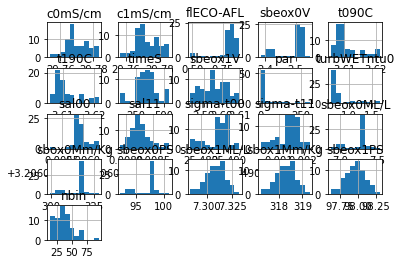

In [6]:
cruise_data['ctd001.cnv'].hist() #first chance for some built in qc

## Time Properties

Not traditionally dealt with for CTD files as they are likely dynamically updated via GPS feed.  However, FOCI tends to label the date/time with the ***at depth*** time-stamp

## Depth Properties and other assumptions

- currently, all processing and binning (1m for FOCI) is done via seabird routines and the windows software.  This may change with the python ctd package for a few tasks

## Add Deployment meta information

In [7]:
#just a dictionary of dictionaries - simple
with open(cruise_meta_file) as file:
    cruise_config = yaml.full_load(file)
cruise_config[cruise_name]

{'CruiseID': 'DY1805',
 'CruiseID_Historic': None,
 'CruiseID_Alternates': None,
 'Project_Leg': '',
 'Vessel': 'R/V Oscar Dyson',
 'ShipID': 'DY',
 'StartDate': datetime.date(2018, 4, 29),
 'EndDate': datetime.date(2018, 5, 10),
 'Project': 'EcoFOCI',
 'ChiefScientist': 'Peter Proctor',
 'StartPort': 'Dutch Harbor, AK',
 'EndPort': 'Dutch Harbor, AK',
 'CruiseLocation': 'Bering Sea',
 'Description': 'FOCI Spring Mooring Survey',
 'CruiseYear': 2018,
 'ctdlogs_pdf_name': 'DY1805_CastLogs.pdf'}

In [8]:
#and if you want a cast from the cruise, just use the consective cast number
cruise_config['CTDCasts']['CTD001']

{'id': 22869,
 'Vessel': 'R/V Oscar Dyson',
 'CruiseID': 'DY1805',
 'Project_Leg': '',
 'UniqueCruiseID': 'DY1805',
 'Project': 'FOCI Spring Mooring Survey',
 'StationNo_altname': 's1h1',
 'ConsecutiveCastNo': 'CTD001',
 'LatitudeDeg': 56,
 'LatitudeMin': 52.28,
 'GeoLocation': None,
 'LongitudeDeg': 164,
 'LongitudeMin': 2.92,
 'GMTDay': 30,
 'GMTMonth': 'Apr',
 'GMTYear': 2018,
 'GMTTime': 69660,
 'DryBulb': 3.7,
 'RelativeHumidity': 98,
 'WetBulb': -99.9,
 'Pressure': 1013,
 'SeaState': '-99',
 'Visibility': '-99',
 'WindDir': 230,
 'WindSpd': 21.0,
 'CloudAmt': '-99',
 'CloudType': '-99',
 'Weather': '-99',
 'SurfaceTemp': -99.9,
 'BottomDepth': 65,
 'StationNameID': 'M2C',
 'MaxDepth': 72,
 'InstrumentSerialNos': 'Press SN =291, Pri Temp SN = 4379, Sec Temp SN =2376, Pri Cond SN = 04-2985, Sec Cond Sn =04-3127, PAR Sn =70547, Fluor Sn = FLNTUS-2057, pri O2 Sn = 1961, sec O2 Sn = 0904, Turbid SN = FLNTUS-2057',
 'Notes': 'Niskin 2 did not close - bottom cap\r\nNiskin 10 did not clo

## Add Instrument meta information

Time, depth, lat, lon should be added regardless (always our coordinates) but for a mooring site its going to be a (1,1,1,t) dataset
The variables of interest should be read from the data file and matched to a key for naming.  That key is in the inst_config file seen below and should represent common conversion names in the raw data

In [9]:
with open(inst_meta_file) as file:
    inst_config = yaml.full_load(file)
inst_config

{'time': {'epic_key': 'TIM_601',
  'name': 'time',
  'generic_name': 'time',
  'standard_name': 'time',
  'long_name': 'date and time since reference time',
  'time_origin': '1900-01-01 00:00:00',
  'units': 'days since 1900-01-01T00:00:00Z'},
 'depth': {'epic_key': 'D_3',
  'generic_name': 'depth',
  'units': 'meter',
  'long_name': 'depth below surface (meters)',
  'standard_name': 'depth'},
 'latitude': {'epic_key': 'LON_501',
  'name': 'latitude',
  'generic_name': 'latitude',
  'units': 'degrees_north',
  'long_name': 'latitude',
  'standard_name': 'latitude'},
 'longitude': {'epic_key': 'LAT_500',
  'name': 'longitude',
  'generic_name': 'longitude',
  'units': 'degrees_east',
  'long_name': 'longitude',
  'standard_name': 'longitude'},
 'temperature_ch1': {'epic_key': 'T_28',
  'generic_name': 'temp channel 1',
  'long_name': 'Sea temperature in-situ ITS-90 scale',
  'standard_name': 'sea_water_temperature',
  'units': 'degree_C'},
 'temperature_ch2': {'epic_key': 'T2_35',
  'ge

In [10]:
#sbe data uses header info to name variables... but we want standard names from the dictionary I've created, so we need to rename column variables appropriately
#rename values to appropriate names, if a value isn't in the .yaml file, you can add it

#*** biggest *** difference between moored and profile data is there may be multiple instruments with the same dataype (e.g.) temperature
# on the same platform.  We _used_ to use the phrases primary and secondary, but will now only refer to them as ch1, ch2 etc
cruise_data['ctd001.cnv'] = cruise_data['ctd001.cnv'].rename(columns={
                        't090C':'temperature_ch1',
                        't190C':'temperature_ch2',
                        'sal00':'salinity_ch1',
                        'sal11':'salinity_ch2',
                        'sbeox0Mm/Kg':'oxy_conc_ch1',
                        'sbeox0ML/L':'oxy_concM_ch1',
                        'sigma-t00':'sigma_t_ch1',
                        'sigma-t11':'sigma_t_ch2',
                        'CStarAt0':'Attenuation',
                        'CStarTr0':'Transmittance',
                        'flECO-AFL':'chlor_fluorescence',
                        'turbWETntu0':'turbidity',
                        'empty':'empty', #this will be ignored
                        'flag':'flag'})

cruise_data['ctd001.cnv'].sample()

,c0mS/cm,c1mS/cm,chlor_fluorescence,sbeox0V,temperature_ch1,temperature_ch2,timeS,sbeox1V,par,turbidity,...,sigma_t_ch1,sigma_t_ch2,oxy_concM_ch1,sbox0Mm/Kg,sbeox0PS,sbeox1ML/L,sbox1Mm/Kg,sbeox1PS,nbin,flag
Pressure [dbar],,,,,,,,,,,,,,,,,,,,,
32.0,29.766485,29.768318,0.8459,2.504,3.6075,3.6075,334.214,2.5978,1.5984,0.6176,...,25.4899,25.4917,7.2995,317.893,97.836,7.3076,318.244,97.945,65.0,False


## Add institutional meta-information


In [11]:
with open(group_meta_file) as file:
    group_config = yaml.full_load(file)
group_config

{'source_documents': 'http://www.oceansites.org/docs/oceansites_data_format_reference_manual.pdf',
 'institution': 'Pacific Marine Environmental Lab (PMEL)',
 'project': 'EcoFOCI',
 'project_url': 'https://www.ecofoci.noaa.gov',
 'principal_investigator': 'Phyllis Stabeno',
 'principal_investigator_email': 'phyllis.stabeno (at) noaa.gov',
 'creator_name': 'Shaun Bell',
 'creator_email': 'shaun.bell (at) noaa.gov',
 'creator_institution': 'PMEL',
 'keywords': 'Mooring, Oceanographic',
 'comment': 'Provisional data',
 'sea_area': 'Bering Sea (BS)',
 'featureType': 'timeSeries',
 'conventions': '”CF-1.6, ~OceanSITES-1.5, ACDD-1.2”',
 'license': '',
 'references': '',
 'citation': '',
 'acknowledgement': ''}

In [12]:
# Add meta data and prelim processing based on meta data
# Convert to xarray and add meta information - save as CF netcdf file
# pass -> data, instmeta, depmeta
cruise_data_nc = ncCFsave.EcoFOCI_CFnc_profile(df=cruise_data['ctd001.cnv'], 
                                instrument_yaml=inst_config, 
                                cruise_yaml=cruise_config)
cruise_data_nc

At this point, you could save your file with the `.xarray2netcdf_save()` method and have a functioning dataset.... but it would be very simple with no additional qc, meta-data, or tuned parameters for optimizing software like ferret or erddap.

In [13]:
# expand the dimensions and coordinate variables
# renames them appropriatley and prepares them for meta-filled values
cruise_data_nc.expand_dimensions()

In [14]:
#build list from columsn in data - if a variable isn't in the yaml file, it will be dropped from the final data fields
cruise_data_nc.variable_meta_data(variable_keys=list(cruise_data['ctd001.cnv'].columns.values),drop_missing=True)
#adding dimension meta needs to come after updating the dimension values... BUG?
cruise_data_nc.dimension_meta_data(variable_keys=['depth','latitude','longitude'])

The following steps can happen in just about any order and are all meta-data driven.  Therefore, they are not required to have a functioning dataset, but they are required to have a well described dataset

In [15]:
#add global attributes
cruise_data_nc.deployment_meta_add(conscastno='CTD001')
cruise_data_nc.get_xdf()

#add instituitonal global attributes
cruise_data_nc.institution_meta_add(group_config)

#add creation date/time - provenance data
cruise_data_nc.provinance_meta_add()

#provide intial qc status field
cruise_data_nc.qc_status(qc_status='unknown')


## Save CF Netcdf files

Currently stick to netcdf3 classic... but migrating to netcdf4 (default) may be no problems for most modern purposes.  Its easy enough to pass the `format` kwargs through to the netcdf api of xarray.

In [22]:
cast = 'CTD001'.split('D')[-1]
cruise_data_nc.xarray2netcdf_save(xdf = cruise_data_nc.get_xdf(),
                           filename=cruise_data_nc.filename_const(manual_label=cruise_name+'c'+cast.zfill(3)+'_ctd'),format="NETCDF4_CLASSIC")

In [23]:
cruise_data_nc.get_xdf()

<xarray.Dataset>
Dimensions:             (depth: 67, latitude: 1, longitude: 1, time: 1)
Coordinates:
  * depth               (depth) float64 1.0 2.0 3.0 4.0 ... 64.0 65.0 66.0 67.0
  * longitude           (longitude) float64 1e+35
  * latitude            (latitude) float64 1e+35
  * time                (time) float64 1e+35
Data variables:
    chlor_fluorescence  (time, depth, latitude, longitude) float64 0.4821 ......
    temperature_ch1     (time, depth, latitude, longitude) float64 3.609 ... ...
    temperature_ch2     (time, depth, latitude, longitude) float64 3.611 ... ...
    par                 (time, depth, latitude, longitude) float64 304.0 ... ...
    salinity_ch1        (time, depth, latitude, longitude) float64 32.07 ... ...
    salinity_ch2        (time, depth, latitude, longitude) float64 32.07 ... ...
    oxy_concM_ch1       (time, depth, latitude, longitude) float64 7.326 ... ...
Attributes: (12/24)
    CruiseID:                      DY1805
    VesselName:                    R/V Oscar Dyson
    WaterDepth:                    65
    source_documents:              http://www.oceansites.org/docs/oceansites_...
    institution:                   Pacific Marine Environmental Lab (PMEL)
    project:                       EcoFOCI
    ...                            ...
    references:                    
    citation:                      
    acknowledgement:               
    date_created:                  2021-04-06T15:53:38Z
    date_modified:                 
    QC_indicator:                  unknown

## Next Steps

QC of data (plot parameters with other instruments)
- be sure to updated the qc_status and the history